In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np

In [59]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset_v2'
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]
classes = list(annotations_dict_train.keys())
print(classes)

['n02165456', 'n02226429', 'n01855672', 'n02077923', 'n01644373', 'n02279972']


In [60]:
from object_detection_helper import GeneratorMultipleOutputs, plot_batch, PlotLosses

In [61]:
target_size=(256, 256)

In [62]:
# classes en None para que tome world tambien
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 10, classes = None,
                                                            concat_output = True,
                                                            target_size=target_size
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 64, classes = None,
                                                              concat_output = True,
                                                          target_size=target_size
                                                         )

Found 3600 images belonging to 7 classes.
Found 720 images belonging to 7 classes.


[0.   0.   0.   0.   1.   0.   0.49 0.54 0.79 0.67 1.  ]


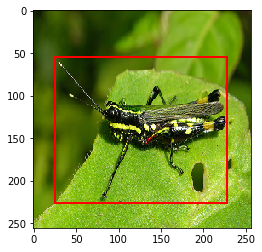

[0.   0.   0.   0.   0.   1.   0.47 0.47 0.8  0.63 1.  ]


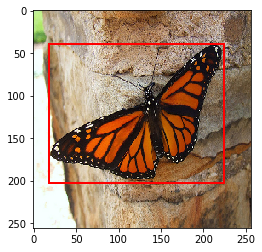

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


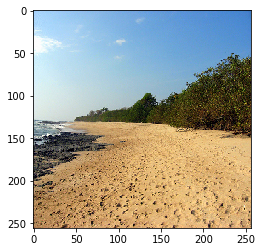

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


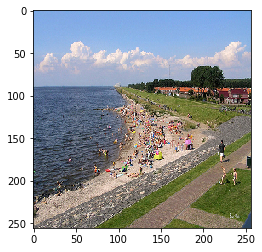

[1.   0.   0.   0.   0.   0.   0.52 0.48 0.26 0.23 1.  ]


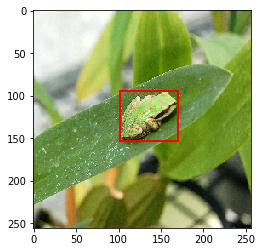

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


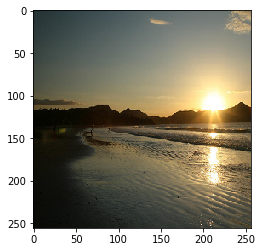

[0.   0.   0.   0.   1.   0.   0.48 0.5  0.57 0.6  1.  ]


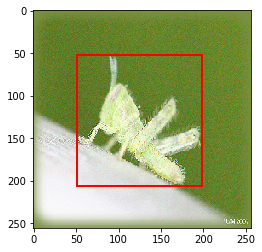

[1.   0.   0.   0.   0.   0.   0.45 0.59 0.32 0.67 1.  ]


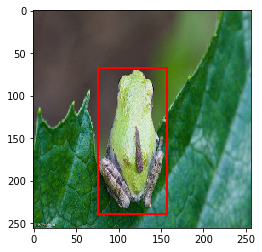

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


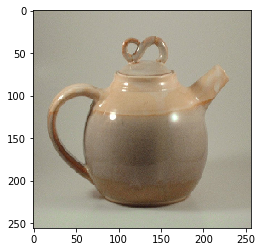

[0.   0.   0.   0.   0.   1.   0.49 0.53 0.72 0.67 1.  ]


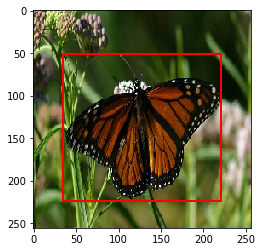

In [63]:
plot_batch(train_generator_multiple_outputs, count=10)

In [110]:
from keras.layers import Activation, Dropout, Dense, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, GlobalMaxPooling2D, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [121]:
n_classes = len(classes)

modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=(*target_size, 3))

flatten_output = Flatten()(modelVGG16.output)
dense_1_output = Activation('relu')(Dense(128, name = 'Dense_1')(flatten_output))
dense_2_output = Activation('relu')(Dense(128, name = 'Dense_2')(dense_1_output))

classification = Dense(n_classes, activation='softmax', name='category_output')(dense_2_output)
bounding_box = Dense(4, activation=None, name='bounding_box')(Dropout(0.25)(dense_2_output))
confidence = Dense(1, activation='sigmoid', name='obj_confidence')(dense_2_output)

all_outs = Concatenate(name='concatenated_outputs')([classification, bounding_box, confidence])
model = Model(inputs=modelVGG16.input, outputs=[all_outs])

In [122]:
N_trainable = 17
print('primer capa entrenable:', model.layers[17].name)

for layer in model.layers[:N_trainable]:
    layer.trainable = False
for layer in model.layers[N_trainable:]:
    layer.trainable = True

primer capa entrenable: block5_conv3


In [123]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

![loss-func-obj-dect](loss-func-obj-dect.png)

# $L = \alpha L_{binary} + \beta L_{categorical} + \gamma L_{boundingbox}$

In [124]:
from custom_losses import custom_loss_IOU, classes_acc, confidence_acc, bounding_box_mse, iou_v2, cat_cross_entropy_loss, custom_loss, mse_custom_loss

In [157]:
#losses = {"concatenated_outputs": mse_custom_loss}
#losses = {"concatenated_outputs": custom_loss}
losses = {"concatenated_outputs": custom_loss_IOU}

metrics = {"concatenated_outputs": [classes_acc, confidence_acc, bounding_box_mse, iou_v2, cat_cross_entropy_loss]}

In [158]:
train_generator = GeneratorMultipleOutputs(annotations_dict_train, 
                                           train_folder, 
                                           concat_output = True,
                                           batch_size=50, 
                                           target_size=target_size,
                                           flip = 'random')
val_generator = GeneratorMultipleOutputs(annotations_dict_val, 
                                         val_folder, 
                                         concat_output = True,
                                         target_size=target_size,
                                         batch_size=60,  
                                         flip = 'random')

Found 3600 images belonging to 7 classes.
Found 720 images belonging to 7 classes.


In [159]:
train_generator.generator.n % train_generator.generator.batch_size

0

In [160]:
val_generator.generator.n % val_generator.generator.batch_size

0

In [163]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_classes_acc', save_best_only=True)
model.compile(loss=losses,
              optimizer=Adam(lr=0.0001),
              metrics=metrics)

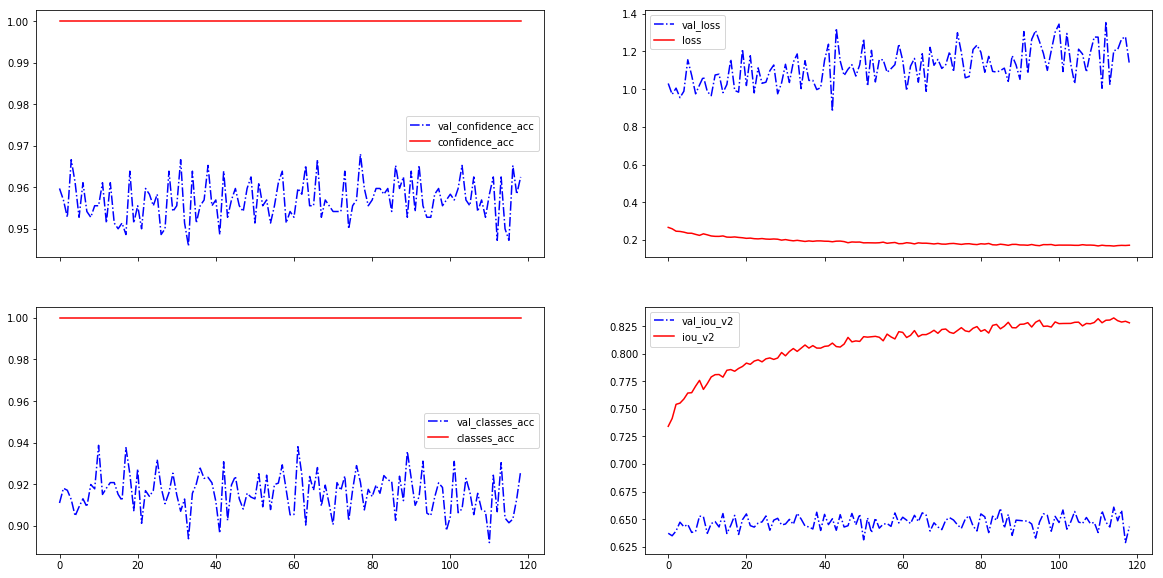

Epoch 120/2000
29/72 [===========>..................] - ETA: 9s - loss: 0.1672 - classes_acc: 1.0000 - confidence_acc: 1.0000 - bounding_box_mse: 0.0073 - iou_v2: 0.8330 - cat_cross_entropy_loss: 2.0102e-04

KeyboardInterrupt: 

In [164]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        epochs=2000,
        validation_data=val_generator, callbacks = [plot_losses, checkpoint]
        )

In [140]:
# model.save_weights('loc_last.hdf5')

In [150]:
# model.load_weights('loc_best.hdf5')

In [165]:
metrics_values = model.evaluate_generator(val_generator_multiple_outputs)
for i, met in enumerate(metrics_values):
    print(model.metrics_names[i], ':', met)

loss : 1.2650772134462993
classes_acc : 0.910405793454912
confidence_acc : 0.9555555555555556
bounding_box_mse : 0.020514769562416605
iou_v2 : 0.6532050675816006
cat_cross_entropy_loss : 0.4850266898671786


Confidence OK: 0.99996924
Class OK: 4
IOU: [0.59400028]


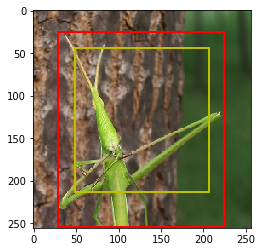

Confidence OK: 0.99968076
Class OK: 4
IOU: [0.59634039]


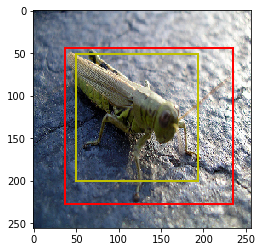

Confidence Failed: 2.254099e-06
Class OK: 3
IOU: [0.03308161]


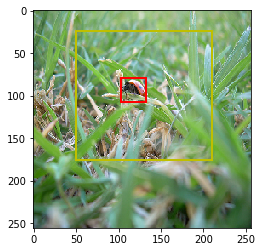

Confidence OK: 0.0


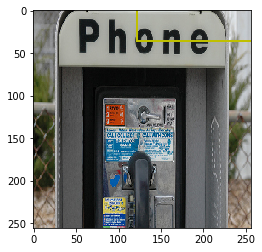

Confidence OK: 0.0


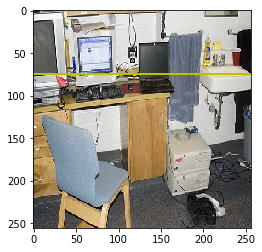

Confidence OK: 0.0


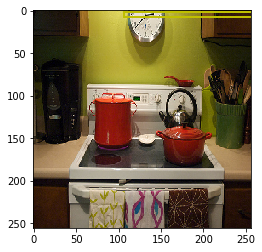

Confidence OK: 3.2277591e-21


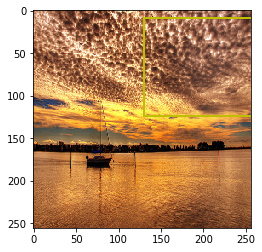

Confidence OK: 9.257466e-36


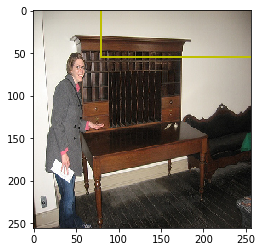

Confidence OK: 0.0


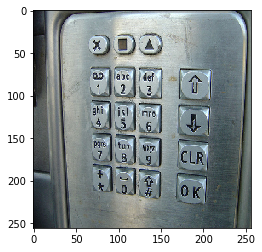

Confidence OK: 0.9999839
Class OK: 3
IOU: [0.57165552]


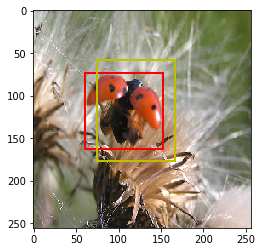

In [167]:
plot_batch(val_generator_multiple_outputs, model, count=10)